In [26]:
import scanpy as sc
import pandas as pd
import mudata as mu
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import rand_score

In [18]:
def compute_ari(adata, label_key_true, label_key_method):
    print(label_key_method)
    print(label_key_true)
    true_labels = adata.obs[label_key_true].to_numpy()
    predicted_labels = adata.obs[label_key_method].to_numpy()
    return adjusted_rand_score(true_labels, predicted_labels)


In [4]:
russell = mu.read_h5mu("/vol/storage/data/simulations/russell_250.h5mu")
russell

MuData object with n_obs × n_vars = 360 × 90052
  var:	'highly_variable'
  2 modalities
    rna:	360 x 36601
      obs:	'cell_count', 'leiden_pca'
      var:	'ens', 'gene', 'type', 'chromosome', 'start', 'end', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'leiden', 'log1p', 'neighbors', 'pca', 'proportion_names'
      obsm:	'X_pca', 'proportions', 'spatial'
      varm:	'PCs'
      layers:	'log_norm'
      obsp:	'connectivities', 'distances'
    atac:	360 x 53451
      obs:	'cell_count', 'leiden_pca', 'leiden_lsi'
      var:	'features', 'highly_variable', 'highly_accessible'
      uns:	'leiden', 'log1p', 'lsi', 'neighbors', 'pca', 'proportion_names'
      obsm:	'X_lsi', 'X_pca', 'proportions', 'spatial'
      varm:	'LSI', 'PCs'
      layers:	'log_norm', 'tfidf_normalized'
      obsp:	'connectivities', 'distances'

In [6]:
russell_sc = mu.read_h5mu("/vol/storage/data/simulations/russel_ref.h5mu")

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


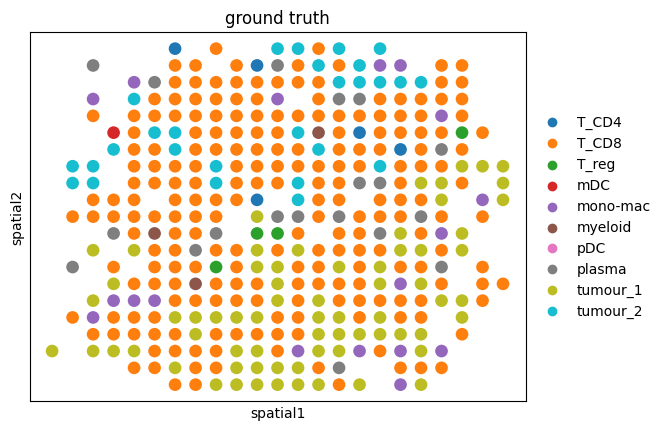

In [7]:
max_prob_cluster = np.argmax(russell.mod["atac"].obsm["proportions"], axis=1)
cluster_id = russell.mod["atac"].uns["proportion_names"]
russell.mod["atac"].obs["ground truth"] = cluster_id[max_prob_cluster]
russell.mod["atac"].obs['ground truth'] = pd.Categorical(russell.mod["atac"].obs['ground truth'], categories=russell_sc.mod["atac"].obs.cell_type.cat.categories)
russell.mod["atac"].uns["cell_type_colors"] = russell_sc.mod["atac"].uns["cell_type_colors"].copy()
sc.pl.embedding(russell.mod["atac"], basis = "spatial", color = "ground truth")

In [8]:
russell

MuData object with n_obs × n_vars = 360 × 90052
  var:	'highly_variable'
  2 modalities
    rna:	360 x 36601
      obs:	'cell_count', 'leiden_pca'
      var:	'ens', 'gene', 'type', 'chromosome', 'start', 'end', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'leiden', 'log1p', 'neighbors', 'pca', 'proportion_names'
      obsm:	'X_pca', 'proportions', 'spatial'
      varm:	'PCs'
      layers:	'log_norm'
      obsp:	'connectivities', 'distances'
    atac:	360 x 53451
      obs:	'cell_count', 'leiden_pca', 'leiden_lsi', 'ground truth'
      var:	'features', 'highly_variable', 'highly_accessible'
      uns:	'leiden', 'log1p', 'lsi', 'neighbors', 'pca', 'proportion_names', 'cell_type_colors', 'ground truth_colors'
      obsm:	'X_lsi', 'X_pca', 'proportions', 'spatial'
      varm:	'LSI', 'PCs'
      layers:	'log_norm', 'tfidf_normalized'
      obsp:	'connectivities', 'distances'

### Cell2Location

In [10]:
russell_atac_ha = "/vol/storage/data/deconvolution_results/cell2location/atac/russell_250_highly_accessible/means_cell_abundance_w_sf.csv"
russell_atac_hv = "/vol/storage/data/deconvolution_results/cell2location/atac/russell_250_highly_variable/means_cell_abundance_w_sf.csv"
russell_rna = "/vol/storage/data/deconvolution_results/cell2location/rna/russell_250_highly_variable/means_cell_abundance_w_sf.csv"
results = [russell_atac_ha, russell_rna, russell_atac_hv]

In [19]:
for result in results:
    dt = pd.read_csv(result, index_col=0)
    dt.columns = dt.columns.str.removeprefix("meanscell_abundance_w_sf_")
    curr = result.split("/")[-2]
    mod = result.split("/")[-3]
    dt.index = russell.obs.index
    
    russell.obsm[curr] = dt
    # Caculate the most probable cluster assignment
    max_prob_cluster = np.argmax(russell.obsm[curr], axis=1)
    # Get the column names
    cluster_id = dt.columns.to_numpy()
    russell.mod["atac"].obs['max_prob_cluster_' + curr + mod] = cluster_id[max_prob_cluster]
    russell.mod["atac"].obs['max_prob_cluster_' + curr + mod] = pd.Categorical(russell.mod["atac"].obs['max_prob_cluster_'+ curr + mod], categories=russell_sc.mod["atac"].obs.cell_type.cat.categories)
    
    print(compute_ari(adata=russell.mod["atac"], label_key_true="ground truth", label_key_method='max_prob_cluster_' + curr + mod))

max_prob_cluster_russell_250_highly_accessibleatac
ground truth
0.4197783571875862
max_prob_cluster_russell_250_highly_variablerna
ground truth
0.45503105140492706
max_prob_cluster_russell_250_highly_variableatac
ground truth
0.412866802689952


In [17]:
russell.mod["atac"].obs[["ground truth", "max_prob_cluster_russell_250_highly_variablerna"]]

,ground truth,max_prob_cluster_russell_250_highly_variablerna
0,tumour_1,tumour_1
1,T_CD8,tumour_1
2,plasma,tumour_1
3,T_CD8,T_CD8
4,tumour_2,tumour_2
...,...,...
355,T_CD8,T_CD8
356,T_CD8,T_CD8
357,tumour_1,tumour_1
358,tumour_1,tumour_1


In [23]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
le.fit_transform(russell.mod["atac"].obs[["ground truth"]])

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([7, 1, 6, 1, 8, 8, 7, 1, 4, 7, 7, 1, 1, 8, 8, 1, 4, 6, 7, 1, 1, 4,
       7, 1, 6, 1, 1, 8, 3, 1, 7, 1, 1, 4, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1,
       8, 4, 1, 1, 1, 1, 4, 1, 1, 1, 5, 1, 1, 1, 1, 8, 1, 1, 6, 1, 7, 1,
       1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, 1, 1, 0, 1, 1, 1, 7,
       7, 1, 5, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 7, 1,
       1, 2, 1, 6, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 7, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 7, 1, 1, 7, 7, 2, 7, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 7, 7, 1, 1, 1, 7, 7, 7, 1, 2, 6, 1, 1, 1,
       1, 1, 4, 1, 6, 8, 7, 7, 4, 1, 1, 1, 1, 1, 7, 1, 6, 8, 8, 1, 1, 8,
       1, 1, 1, 8, 7, 1, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 8, 5, 1, 1, 1,
       8, 1, 1, 6, 7, 7, 7, 1, 1, 7, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 8, 1,
       8, 7, 4, 7, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 0, 1, 6, 8, 8, 1, 7, 7,
       1, 7, 7, 1, 6, 1, 1, 6, 8, 1, 1, 1, 1, 8, 4, 8, 4, 1, 4, 7, 1, 1,
       4, 1, 7, 7, 1, 1, 1, 1, 0, 1, 1, 1, 8, 4, 7,

In [24]:
le.fit_transform(russell.mod["atac"].obs[["max_prob_cluster_russell_250_highly_variablerna"]])

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([7, 7, 7, 1, 8, 8, 7, 1, 4, 7, 7, 0, 1, 8, 8, 1, 4, 8, 7, 1, 1, 4,
       7, 1, 6, 1, 1, 8, 3, 7, 7, 1, 1, 7, 7, 7, 6, 1, 1, 1, 1, 1, 8, 1,
       8, 4, 1, 1, 2, 1, 4, 1, 1, 3, 5, 1, 1, 1, 8, 8, 1, 3, 6, 1, 7, 1,
       1, 7, 7, 1, 6, 1, 6, 8, 1, 1, 8, 8, 8, 1, 1, 1, 1, 0, 4, 1, 7, 1,
       7, 1, 5, 6, 6, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 4, 7, 7, 7, 1, 7, 1,
       1, 2, 1, 6, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 7, 1, 7, 1,
       1, 1, 1, 1, 1, 4, 6, 8, 1, 1, 6, 1, 7, 7, 7, 1, 7, 7, 7, 6, 7, 1,
       8, 1, 1, 1, 1, 1, 1, 0, 7, 1, 1, 7, 1, 7, 7, 1, 7, 2, 6, 1, 8, 1,
       1, 1, 4, 1, 1, 1, 7, 7, 7, 1, 4, 1, 1, 1, 7, 7, 6, 8, 8, 1, 1, 1,
       1, 0, 1, 1, 7, 7, 7, 7, 7, 7, 7, 1, 1, 6, 1, 1, 1, 8, 5, 1, 1, 8,
       4, 1, 1, 8, 7, 1, 7, 1, 7, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 6, 8, 8,
       8, 1, 4, 7, 1, 1, 7, 7, 1, 1, 6, 6, 1, 6, 0, 1, 8, 1, 8, 1, 7, 7,
       1, 7, 7, 1, 6, 1, 1, 6, 8, 1, 1, 1, 1, 1, 4, 8, 6, 1, 4, 7, 7, 1,
       7, 1, 7, 7, 1, 1, 1, 6, 1, 4, 1, 1, 4, 4, 5,

In [25]:
adjusted_rand_score(le.fit_transform(russell.mod["atac"].obs[["ground truth"]])
                    , le.fit_transform(russell.mod["atac"].obs[["max_prob_cluster_russell_250_highly_variablerna"]]))

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.45503105140492706

In [27]:
rand_score(le.fit_transform(russell.mod["atac"].obs[["ground truth"]])
                    , le.fit_transform(russell.mod["atac"].obs[["max_prob_cluster_russell_250_highly_variablerna"]]))

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7486072423398329

### RCTD

In [20]:
russell_atac_ha = "/vol/storage/data/deconvolution_results/rctd/atac/russell_250_highly_accessible/estimated_proportions.csv"
russell_atac_hv = "/vol/storage/data/deconvolution_results/rctd/atac/russell_250_highly_variable/estimated_proportions.csv"
russell_rna = "/vol/storage/data/deconvolution_results/rctd/rna/russell_250_highly_variable/estimated_proportions.csv"
results = [russell_atac_ha, russell_rna, russell_atac_hv]

In [21]:
for result in results:
    dt = pd.read_csv(result, index_col=0)
    print(dt.columns)
    curr = result.split("/")[-2] + "_rctd"
    mod = result.split("/")[-3]
    dt.index = russell.obs.index
    russell.obsm[curr] = dt
    # Caculate the most probable cluster assignment
    max_prob_cluster = np.argmax(russell.obsm[curr], axis=1)
    # Get the column names
    cluster_id = dt.columns.to_numpy()
    russell.mod["atac"].obs['max_prob_cluster_' + curr + mod] = cluster_id[max_prob_cluster]
    russell.mod["atac"].obs["max_prob_cluster_" + curr + mod] = pd.Categorical(
        russell.mod["atac"].obs["max_prob_cluster_" + curr + mod],
        categories=russell_sc.mod["atac"].obs.cell_type.cat.categories,
    )
    print(compute_ari(adata=russell.mod["atac"], label_key_true="ground truth", label_key_method='max_prob_cluster_' + curr + mod))

Index(['T_CD4', 'T_CD8', 'T_reg', 'mDC', 'mono-mac', 'myeloid', 'pDC',
       'plasma', 'tumour_1', 'tumour_2'],
      dtype='object')
max_prob_cluster_russell_250_highly_accessible_rctdatac
ground truth
0.1303857644442297
Index(['T_CD4', 'T_CD8', 'T_reg', 'mDC', 'mono-mac', 'myeloid', 'pDC',
       'plasma', 'tumour_1', 'tumour_2'],
      dtype='object')
max_prob_cluster_russell_250_highly_variable_rctdrna
ground truth
0.1367259591926779
Index(['T_CD4', 'T_CD8', 'T_reg', 'mDC', 'mono-mac', 'myeloid', 'pDC',
       'plasma', 'tumour_1', 'tumour_2'],
      dtype='object')
max_prob_cluster_russell_250_highly_variable_rctdatac
ground truth
0.1370054351779585
